In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import datetime
import gc
import random
import re
import operator

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score,precision_score,recall_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.optimizer import Optimizer

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['quora-insincere-questions-classification', 'fakenews']


In [2]:
fakenews=pd.read_csv('../input/fakenews/fakenews.csv')

In [3]:
fakenews = fakenews.sort_values(by=['Stance'])

In [4]:
fakenews.head()

,Headline,Body ID,Stance,articleBody
9379,Utah Man Hospitalized After Winning Eggnog Chu...,667,agree,A Utah man was rushed to the hospital after he...
4640,Italian fisherman catches monstrous 280-pound ...,2196,agree,"With its huge, gaping mouth, it looks big enou..."
4639,Bunbury local discovered a spider had burrowed...,1502,agree,"If Bali belly, dengue fever and dangerous drin..."
30653,"Gill Rosenberg, Canadian-Israeli Woman Feared ...",1976,agree,Sources in the Kurdish underground in Syria de...
46608,An Indian Civil Servant Just Got Sacked After ...,1951,agree,An executive engineer at the Central Public Wo...


In [5]:
glove='../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt';

In [6]:
def glove_dict(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [7]:
%%time
glove_embeddings_dict=glove_dict(glove)

CPU times: user 2min 24s, sys: 5.08 s, total: 2min 29s
Wall time: 2min 28s


In [8]:
print("Number of embeddings loaded",len(glove_embeddings_dict))

Number of embeddings loaded 2196016


In [9]:
def fun(paragraph):
    sentences = paragraph.split("\n\n")
    Max = 0
    for sentence in sentences:
        Max = max(len(sentence.split()),Max)
    return Max
        

In [10]:
fakenews['Headline']=fakenews['Headline'].apply(lambda x:x.lower())
fakenews['articleBody']=fakenews['articleBody'].apply(lambda x:x.lower())
print(fakenews.shape)
fakenews.head()

(49972, 4)


,Headline,Body ID,Stance,articleBody
9379,utah man hospitalized after winning eggnog chu...,667,agree,a utah man was rushed to the hospital after he...
4640,italian fisherman catches monstrous 280-pound ...,2196,agree,"with its huge, gaping mouth, it looks big enou..."
4639,bunbury local discovered a spider had burrowed...,1502,agree,"if bali belly, dengue fever and dangerous drin..."
30653,"gill rosenberg, canadian-israeli woman feared ...",1976,agree,sources in the kurdish underground in syria de...
46608,an indian civil servant just got sacked after ...,1951,agree,an executive engineer at the central public wo...


In [11]:
fakenews.iloc[0].articleBody

'a utah man was rushed to the hospital after he chugged a quart of eggnog in 12 seconds during a contest at an office holiday party, he said.\n\n"everyone knows i\'m pretty competitive," ryan roche of lehi, utah, told abc news today, explaining how his colleagues talked him into participating just as he was leaving the party with his family earlier this month.\n\n"i just decided i was going to win. so i pretty much just opened it up and poured it down my throat," he said.\n\nhomemade eggnog can kill salmonella with booze\nroche, 33, said he shaved 10 seconds off the previous best time of 22 seconds that day, earning him bragging rights and a $50 gift certificate to ruth\'s chris steak house. but the glory was short-lived: later, at home, he started to feel sick.\n\n"two hours later i was laying on the couch, shaking uncontrollably, nauseous, having fevers and panting," said roche, who works in sales.\n\nhis friend took him to the hospital while his wife stayed home with their three chi

In [12]:
fakenews['Num_sen_body']=fakenews['articleBody'].apply(lambda x:len(x.split("\n\n")))

In [13]:
fakenews['Num_words_headline']=fakenews['Headline'].apply(lambda x:len(x.split()))
fakenews['Num_words_body']=fakenews['articleBody'].apply(fun)

In [14]:
print("The average no of sentences in body is",fakenews['Num_sen_body'].mean())

The average no of sentences in body is 11.065676778996238


In [15]:
print("The average word length in src_tweet is",fakenews['Num_words_headline'].mean(),
                      "and in reply_tweet is",fakenews['Num_words_body'].mean())

The average word length in src_tweet is 11.12647082366125 and in reply_tweet is 82.38897782758345


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


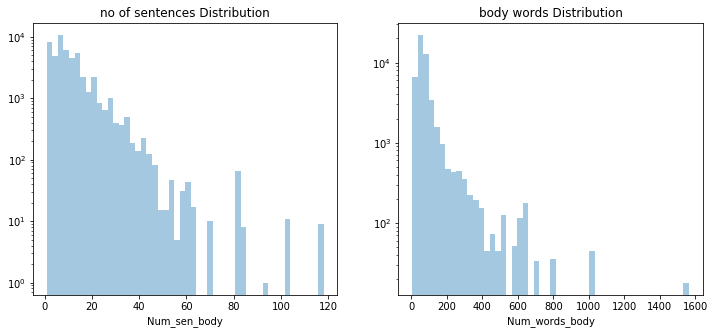

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(fakenews['Num_sen_body'],kde=False)
plt.yscale("log")
plt.title("no of sentences Distribution")
plt.subplot(122)
sns.distplot(fakenews['Num_words_body'],kde=False)
plt.yscale("log")
plt.title("body words Distribution")
plt.show()

In [17]:
fakenews['Headline']=fakenews['Headline'].apply(lambda x:x.replace("’","'"))
fakenews['articleBody']=fakenews['articleBody'].apply(lambda x:x.replace("’","'"))

In [18]:
import string
PUNC = string.punctuation.replace('%','')
PUNC = PUNC+"”“‘‘"

In [19]:
len(PUNC)

35

In [20]:
url = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+] |[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

In [21]:
contraction_mapping={"haven't":"have not","hadn't":"had not","wasn't":"was not","he's":"he is",
                     "couldn't":"could not","she's":"she is","i'm":"i am","we've":"we have",
                     "wouldn't":"would not","that's":"that is","we're":"we are","isn't":"is not",
                     "hasn't":"has not","they're":"they are","she's":"she is","he's":"he is","weren't":"were not",
                    "there's":"there is","i've":"i have","you've":"you have","we've":"we have","we'd":"we would",
                    "we're":"we are","who's":"who is","they'll":"they will","what's":"what is","she'd":"she would",
                    "aren't":"are not","shouldn't":"should not","There's":"There is",
                     "we'll":"we will","I`m":"I am","you're":"you are","i'd":"i would","he'll":"he will",
                    "they'd":"they would","didn't":"did not","you'll":"you will",
                    "would've":"would have","you\'re":"you are","i'll":"i will",
                    "film/theater":"film or theater","that\'s":"that is","we'd":"we would",
                    "they've":"they have","she'll":"she will","haven't":"have not","it'll":"it will","you'd":"you would",
                    "i've":"i have","i`ve":"i have","she'll":"she will","it'll":"it will","hadn't":"had not","i\'ve":"i have",
                     "you\'re":"you are","b'day":"birthday","don't":"do not","it'd":"it would","you've":"you have",
                    "don\'t":"do not","what\'s":"what is","won't":"will not",
                    "he'd":"he would","don't":"do not","here's":"here is","i'll":"i will","let's": "let us",
                    "i'd":"i had","when's": "when is","y'all":"you all","it's":"it is","can't":"cannot","what's":"what is",
                    "where's":"where is","ain't":"are not","let´s":"let us","gov't":"government"}
def replace_contraction_mapping(x):
    for contract in contraction_mapping.keys():
        x=x.replace(contract,contraction_mapping[contract])
    return x
def stripof(x):
    sentences = x.split("\n\n")
    Max = 0
    out = ''
    for sentence in sentences:
        for word in sentence.split():
            if not url.search(word) and word[0]!='@':
                word= word.strip(PUNC)
                out+=re.sub("\'s$", "", word)+' '
        out = out[0:len(out)-1]
        out+=".\n\n"
    return out
fakenews['Headline']=fakenews['Headline'].apply(lambda x:stripof(x))
fakenews['articleBody']=fakenews['articleBody'].apply(lambda x:stripof(x))
fakenews['Headline']=fakenews['Headline'].apply(lambda x:replace_contraction_mapping(x))
fakenews['articleBody']=fakenews['articleBody'].apply(lambda x:replace_contraction_mapping(x))
src_news_cleaned=fakenews['Headline']
body_news_cleaned=fakenews['articleBody']


In [22]:
fakenews.iloc[0].articleBody

'a utah man was rushed to the hospital after he chugged a quart of eggnog in 12 seconds during a contest at an office holiday party he said.\n\neveryone knows i am pretty competitive ryan roche of lehi utah told abc news today explaining how his colleagues talked him into participating just as he was leaving the party with his family earlier this month.\n\ni just decided i was going to win so i pretty much just opened it up and poured it down my throat he said.\n\nhomemade eggnog can kill salmonella with booze roche 33 said he shaved 10 seconds off the previous best time of 22 seconds that day earning him bragging rights and a 50 gift certificate to ruth chris steak house but the glory was short-lived later at home he started to feel sick.\n\ntwo hours later i was laying on the couch shaking uncontrollably nauseous having fevers and panting said roche who works in sales.\n\nhis friend took him to the hospital while his wife stayed home with their three children.\n\nin roche case the eg

In [23]:
# print(src_tweet_cleaned)
# print(reply_tweet_cleaned)
news=pd.concat([src_news_cleaned,body_news_cleaned])
news

9379     utah man hospitalized after winning eggnog chu...
4640     italian fisherman catches monstrous 280-pound ...
4639     bunbury local discovered a spider had burrowed...
30653    gill rosenberg canadian-israeli woman feared k...
46608    an indian civil servant just got sacked after ...
39817    watch us marine get shot in head by taliban sn...
21404    italian catches huge wels catfish is it a reco...
13896    dogs do go to heaven… and cats and horses pope...
13869    that boko haram ceasefire in nigeria is not a ...
26408    no a spider probably did not crawl through a m...
34286    new isis video shows militants seizing weapons...
4611     video messaging service verifies timing of cnn...
13908    banksy arrest hoax us website claims street ar...
39796    homeless man receives 100 then shocks everyone...
21385    man chops off own penis after being dumped by ...
4600     pictured recent muslim convert michael zehaf-b...
34301    these lego instructions from 1974 are awesome .

In [24]:
# print(src_news_cleaned)
# print(reply_news_cleaned)
# print(news)

In [25]:
# phemestance['SourceTweet'].head()
# phemestance['ReplyTweet'].head()
# phemestance.head()

In [26]:
def sen(x):
    return x.split()
#src_sentences=src_news_cleaned.apply(sen)
#body_sentences=body_news_cleaned.apply(sen)
news_sentences=news.apply(sen)

In [27]:
# src_sentences
# body_sentences
# news_sentences

In [28]:
def build_vocab(sentences,verbose=True):
    vocab={}
    for sentence in tqdm(sentences,disable=(not verbose)):
        for word in sentence:
#             word = word.lower()
#             word = word.strip(PUNC)
#             word = re.sub("\'s$", "", word)
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
                
    print("Number of words found in vocab are",len(vocab.keys()))
    return dict(sorted(vocab.items(), key=operator.itemgetter(1))[::-1])
#src_vocab=build_vocab(src_sentences)
#body_vocab=build_vocab(body_sentences)
news_vocab=build_vocab(news_sentences)

100%|██████████| 99944/99944 [00:04<00:00, 24247.62it/s]


Number of words found in vocab are 30586


In [29]:
def check_coverage(vocab,glove_embeddings_dict):
    # words that dont have embeddings
    oov={}
    # stores words that have embeddings
    a=[]
    i=0
    k=0
    for word in tqdm(vocab.keys()):
        #print(word)
#         word = word.lower()
#         word = word.strip(PUNC)
#         word = re.sub("\'s$", "", word)
        #print(word,(glove_embeddings_dict.get(word) is not None))
        if glove_embeddings_dict.get(word) is not None:                    # implies that word has embedding
#             print(word)
            a.append(word)
            k=k+vocab[word]
        elif word != '' and word[0] != '#' and word[0]!='@':
                oov[word]=vocab[word]
                i=i+vocab[word]
    
    print("Total embeddings found in vocab are",len(a)/len(vocab)*100,"%")
    print("Total embeddings found in text are",k/(k+i)*100,"%")
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return dict(sorted_x)
oov=check_coverage(news_vocab,glove_embeddings_dict)


100%|██████████| 30586/30586 [00:00<00:00, 745980.32it/s]

Total embeddings found in vocab are 77.27718564048911 %
Total embeddings found in text are 97.07979339999245 %


In [30]:
oov

{'—': 22971,
 '–': 10961,
 'emwazi': 7047,
 'isil': 4420,
 'al-baghdadi': 4416,
 'kobani': 4115,
 'syria.': 4072,
 'sotloff': 3878,
 '2014.': 3855,
 'baghdadi': 3369,
 'iraq.': 3286,
 'godane': 3195,
 'reported.': 2993,
 'kobane': 2780,
 'zehaf-bibeau': 2695,
 '2015.': 2658,
 'shekau': 2636,
 'al-shabaab': 2578,
 'isis.': 2515,
 'foley.': 1933,
 'chibok': 1913,
 'ebola.': 1822,
 'al-dulaimi': 1727,
 '…': 1667,
 'tuesday.': 1658,
 'al-shabab': 1564,
 'raqqa': 1549,
 'hoax.': 1537,
 'cnn.': 1441,
 'chaffetz': 1342,
 'kadalim': 1295,
 'london.': 1290,
 'hairgate': 1275,
 'militants.': 1261,
 'incident.': 1247,
 'dulaimi': 1214,
 'africa.': 1210,
 'yo-jong': 1207,
 'bibeau': 1200,
 'bethell': 1200,
 'bergdahl': 1189,
 'thursday.': 1168,
 'tsarnaev': 1147,
 'wednesday.': 1137,
 'scotland.': 1107,
 'cirillo': 1088,
 'kobani.': 1071,
 'titchmarsh': 1055,
 'us-led': 1046,
 'monday.': 1029,
 'oberholtzer': 1022,
 'chilpancingo': 1018,
 'tukur': 984,
 'claims.': 971,
 'omidyar': 951,
 'abdel-maj

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = []
features = []
for i in range(fakenews.shape[0]):
    #print(fakenews.loc[fakenews['Headline']==src,'articleBody'].values)
    corpus = [fakenews.iloc[i].Headline]+list(fakenews.iloc[i].articleBody.split("\n\n"))
    #print(corpus)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    tfidf.append(X)
    features.append(vectorizer.get_feature_names())

In [32]:
list_of_claims = []
m = 0
for i in tqdm(range(fakenews.shape[0])):
    if i == 30000:
        break
    corpus = [fakenews.iloc[i].Headline]+list(fakenews.iloc[i].articleBody.split("\n\n"))
    
    claim = []
    n = 0
    temp_tfidf = tfidf[m].toarray()
    temp_features = features[m]
    for sentence in corpus:
        embedding = np.zeros((300,1))
        #print(temp_features.index('an'))
        #print(sentence)
        num_words=0
        flag = 0
        for word in sentence.split():
#             print(word)
            if word not in oov and word in temp_features:
                #print(m," ",word)
                emb = np.reshape(glove_embeddings_dict.get(word),(300,1))
                embedding += (temp_tfidf[n][temp_features.index(word)] * emb)
                num_words = num_words+1
                flag = 1
            elif word in temp_features:
                embedding += (temp_tfidf[n][temp_features.index(word)] * np.random.rand(300,1))
                num_words = num_words+1
                flag = 1
                
        n = n+1 
        if num_words==0:
            num_words=1
        embedding/=num_words
        if flag == 1:
            claim.append(embedding)
    m=m+1
    list_of_claims.append(claim)
        
        


 60%|██████    | 29986/49972 [02:33<01:54, 173.85it/s]

In [33]:
labels = []
for i in tqdm(range(fakenews.shape[0])):
    if i ==30000:
        break
    labels.append(fakenews.iloc[i].Stance)


 59%|█████▉    | 29684/49972 [00:05<00:03, 5486.06it/s]

In [34]:
# Out = [['claims','label']]
Out=[]
for i in range(len(labels)):
    g = np.array(list_of_claims[i])[:,:,0]
#     print(g.shape)
    temp = [g,labels[i]]
    Out.append(temp)

In [35]:
Out = np.array(Out)

In [36]:
# Claims = Out[:,0]
# label = Out[:,1]

In [37]:
# Claims.shape

In [38]:
# Claims[0]

In [39]:
np.save(file='fakenews.npy',arr=np.array(Out))
print("Done")

 60%|██████    | 29986/49972 [02:53<01:54, 173.85it/s]

Done



 59%|█████▉    | 29684/49972 [00:18<00:03, 5486.06it/s]

In [40]:
#import hickle
# import h5py

In [41]:
# dt = h5py.special_dtype(vlen=np.dtype('float64'))

In [42]:
#h5py.dump(Claims, 'fakenews.hkl',dtype=dt )

In [43]:
# hf = h5py.File('fakenews.h5', 'w')
# hf.create_dataset('fakenews', data=Claims,dtype=dt)

In [44]:
# hf.close()

In [45]:
# import csv
# with open('label.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(label)

In [46]:
# hf1 = h5py.File('fakenews.h5', 'r')